In [4]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from transformers import InformerConfig, InformerForPrediction
from one.api import ONE
from sklearn.model_selection import train_test_split

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from utils.load_meso_session import MesoscopeSession

print("STEP 1: Loading data from IBL...")

one = ONE()
SESSION_INDEX = 0
# session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', SESSION_INDEX, True)
# Using a 1000s window as in your example. You can remove the time_window argument to use the full session.
# activity_matrix, timestamps = session.get_activity_matrix()

activity_matrix, timestamps, eid = MesoscopeSession.load_session_from_hdf5('../DATA/activity_raw.h5')
print(f"Successfully loaded data. Activity matrix shape: {activity_matrix.shape}")

STEP 1: Loading data from IBL...


KeyboardInterrupt: 


STEP 2: Normalizing the continuous activity matrix using Z-score...
Normalization complete.
New normalized data stats: Mean=0.0000, Std=0.9997


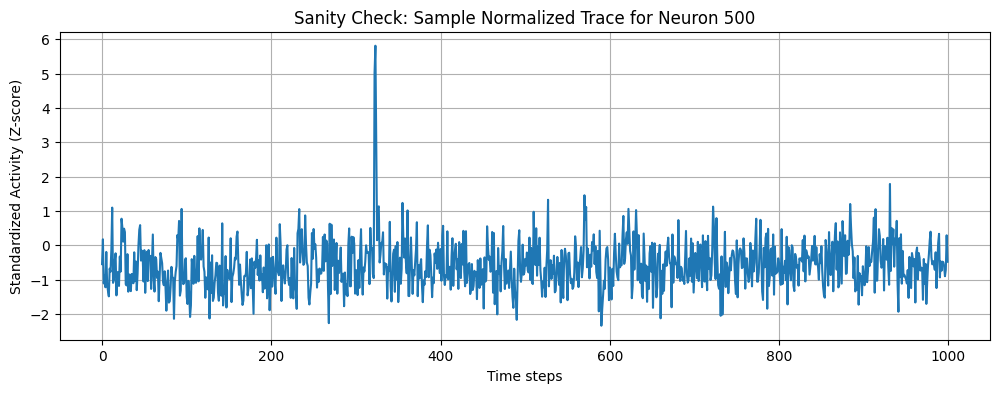


STEP 3: Defining a memory-efficient lazy-loading Dataset...
Lazy Dataset class defined. No windows have been created in RAM.

STEP 4: Instantiating Lazy Dataset and splitting indices...
Total possible windows (samples): 18829
Data split: 16946 training samples, 1883 validation samples.
DataLoaders are ready. Data will be generated on-the-fly during training.


In [2]:
# ===================================================================
# Step 2: CORRECTED Normalization for Continuous Data
# ===================================================================
print("\nSTEP 2: Normalizing the continuous activity matrix using Z-score...")

# --- We will standardize each neuron (column) independently ---
# Calculate the mean and standard deviation for each neuron across all time points
mean_vals = np.mean(activity_matrix, axis=0)
std_vals = np.std(activity_matrix, axis=0)

# Add a small epsilon to standard deviation to prevent division by zero for flat-line neurons
epsilon = 1e-8
std_vals[std_vals < epsilon] = epsilon

# Apply the Z-score normalization formula
activity_matrix_normalized = (activity_matrix - mean_vals) / std_vals

print("Normalization complete.")

# --- SANITY CHECK: Verify the new normalized data ---
# The overall mean should be very close to 0, and the std dev close to 1.
print(f"New normalized data stats: Mean={np.mean(activity_matrix_normalized):.4f}, Std={np.std(activity_matrix_normalized):.4f}")

# Plot a sample trace to visually confirm it's not all ones
plt.figure(figsize=(12, 4))
plt.title("Sanity Check: Sample Normalized Trace for Neuron 500")
plt.plot(activity_matrix_normalized[:1000, 500]) # Plot first 1000 steps of a sample neuron
plt.xlabel("Time steps")
plt.ylabel("Standardized Activity (Z-score)")
plt.grid(True)
plt.show()


# ===================================================================
# Step 3: Lazy Data Preparation via a Custom Dataset
# ===================================================================
print("\nSTEP 3: Defining a memory-efficient lazy-loading Dataset...")

# --- Define Model/Data Parameters (we need these for the Dataset) ---
context_length = int(50 * 4.9)
prediction_length = 1
# prediction_length = int(2 * 4.9)
# Use your existing config object or redefine it here
config = InformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=activity_matrix_normalized.shape[1],
    num_time_features=1,
    d_model=256,                 # Increase embedding dimension
    encoder_layers=6,            # Add more layers
    decoder_layers=6,            # Add more layers
    encoder_attention_heads=8,   # Heads can stay the same or increase
    decoder_attention_heads=8,
    encoder_ffn_dim=512,         # Increase feed-forward dimension
    decoder_ffn_dim=512,
    # attention_type="full" #this made it worse
)
max_lag = max(config.lags_sequence)
past_sequence_length = context_length + max_lag
total_sequence_length = past_sequence_length + prediction_length

# Create a normalized time feature (from 0 to 1) once
time_feature = (timestamps / timestamps.max()).astype(np.float32)

class MesoLazyDataset(Dataset):
    """A PyTorch Dataset that generates time-series windows on-the-fly."""
    
    def __init__(self, source_activity, source_time, total_len):
        """
        Initializes the dataset. Does NOT create windows.
        Stores references to the source data and configuration.
        """
        self.source_activity = source_activity
        self.source_time = source_time
        self.total_sequence_length = total_len

    def __len__(self):
        """Returns the total number of possible windows."""
        return len(self.source_activity) - self.total_sequence_length + 1

    def __getitem__(self, idx):
        """
        This is the core of lazy loading. It's called by the DataLoader
        for one index `idx` at a time.
        """
        # Define the start and end of the full window for this item
        start_slice = idx
        end_slice = idx + self.total_sequence_length
        
        # Slice the window from the source data
        window_activity = self.source_activity[start_slice:end_slice]
        window_time = self.source_time[start_slice:end_slice]
        
        # Split the window into past and future parts
        past_val = window_activity[:past_sequence_length]
        future_val = window_activity[past_sequence_length:]
        
        past_time = window_time[:past_sequence_length]
        future_time = window_time[past_sequence_length:]
        
        # Convert ONLY this single sample's slices to Tensors
        past_values = torch.from_numpy(past_val).float()
        future_values = torch.from_numpy(future_val).float()
        past_time_features = torch.from_numpy(past_time[:, np.newaxis]).float()
        future_time_features = torch.from_numpy(future_time[:, np.newaxis]).float()
        past_observed_mask = torch.ones_like(past_values)
        
        return (past_values, past_time_features, future_values,
                future_time_features, past_observed_mask)

# THIS REPLACES THE ENTIRE EAGER DATA PREPARATION FOR LOOP
# The print statement below will be executed instantly, because no data is being processed yet.
print("Lazy Dataset class defined. No windows have been created in RAM.")


# ===================================================================
# Step 4: Split Data and Set Up DataLoaders (Modified)
# ===================================================================
print("\nSTEP 4: Instantiating Lazy Dataset and splitting indices...")

# --- Instantiate our NEW lazy dataset ---
# It holds references to the large arrays, but doesn't copy or process them.
full_dataset = MesoLazyDataset(
    source_activity=activity_matrix_normalized,
    source_time=time_feature,
    total_len=total_sequence_length
)

print(f"Total possible windows (samples): {len(full_dataset)}")

# --- Split indices into training and validation sets ---
indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42, shuffle=True)

# --- Create Subset objects, which are lightweight wrappers ---
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)

# --- Create DataLoaders from the Subsets ---
# The DataLoader will now call `full_dataset.__getitem__` for indices
# in the train_subset or val_subset.
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Data split: {len(train_subset)} training samples, {len(val_subset)} validation samples.")
print("DataLoaders are ready. Data will be generated on-the-fly during training.")

In [3]:
# --- Setup Model and Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InformerForPrediction(config)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0)

# --- Hyperparameters for the new training regime ---
# We still keep scale regularization as a safety measure.
SCALE_REG_WEIGHT = 0.00 

# ===================================================================
# Step 5: Training & Validation Loop for Continuous Data
# ===================================================================
print("\nSTEP 5: Starting Training & Validation Loop for Continuous Data...")
epochs = 20

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    for i, batch in enumerate(train_loader):
        p_vals, p_time, f_vals, f_time, p_obs_mask = [b.to(device) for b in batch]
        optimizer.zero_grad()
        
        # --- 1. Get the model's own calculated loss ---
        # We can use the model's forward pass directly now. It calculates the NLL internally.
        outputs = model(
            past_values=p_vals,
            past_time_features=p_time,
            past_observed_mask=p_obs_mask,
            future_values=f_vals,
            future_time_features=f_time,
            return_dict=True,
        )
        nll_loss = outputs.loss

        # --- 2. Calculate the Scale Regularization Loss ---
        # We need to manually get the distribution to access the scale parameter.
        # This requires one extra forward pass on the base model, but it's worth it for stability.
        with torch.no_grad(): # We don't need gradients for this part of the calculation
            base_model_outputs = model.model(
                past_values=p_vals, past_time_features=p_time, past_observed_mask=p_obs_mask,
                future_values=f_vals, future_time_features=f_time, return_dict=True
            )
        params = model.parameter_projection(base_model_outputs.last_hidden_state)
        distribution = model.output_distribution(params, loc=base_model_outputs.loc, scale=base_model_outputs.scale)
        scale = distribution.scale + 1e-8
        scale_reg_loss = torch.mean(-torch.log(scale))
        
        # --- 3. Combine the two loss terms ---
        loss = nll_loss + (SCALE_REG_WEIGHT * scale_reg_loss)
        
        # --- Backpropagation on the combined loss ---
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            p_vals, p_time, f_vals, f_time, p_obs_mask = [b.to(device) for b in batch]
            
            # Get the standard, un-weighted validation loss
            outputs = model(
                past_values=p_vals, past_time_features=p_time, past_observed_mask=p_obs_mask,
                future_values=f_vals, future_time_features=f_time, return_dict=True
            )
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # --- Print Epoch Results ---
    print(f"--- End of Epoch {epoch+1}/{epochs} ---")
    print(f"  Average Training Loss (NLL + Scale Pen): {avg_train_loss:.4f}")
    print(f"  Average Validation Loss (NLL): {avg_val_loss:.4f}")

print("\n--- Training Complete ---")

# --- Save the trained model for future inference ---
output_dir = "./informer_calcium_model_continuous"
model.save_pretrained(output_dir)
print(f"Model saved to '{output_dir}'")


STEP 5: Starting Training & Validation Loop for Continuous Data...
--- End of Epoch 1/20 ---
  Average Training Loss (NLL + Scale Pen): 8459.1060
  Average Validation Loss (NLL): 8209.1132
--- End of Epoch 2/20 ---
  Average Training Loss (NLL + Scale Pen): 8105.3942
  Average Validation Loss (NLL): 8059.6798
--- End of Epoch 3/20 ---
  Average Training Loss (NLL + Scale Pen): 7959.7829
  Average Validation Loss (NLL): 8019.3596


KeyboardInterrupt: 

STEP 1: Loading trained model...
Model loaded and set to evaluation mode.

STEP 2: Preparing a sample using the lazy dataset and generating forecast...
Evaluating window starting at time point: 2900
Forecast generated successfully.

STEP 3: Performing population-level evaluation with more metrics...

--- Overall Performance (All Neurons) ---
  Mean Squared Error (MSE): 0.572329
  Mean Absolute Error (MAE): 0.545035

--- Analysis on Subset of 100 Most Active Neurons ---
Selected a subset of 100 neurons with highest future variance.
Sparsity (GT vs. Forecast): 0.24 vs. 0.26
Mean Activity (GT vs. Forecast): 1.6810 vs. 0.2819
Mean Correlation across 100 neurons: -0.003


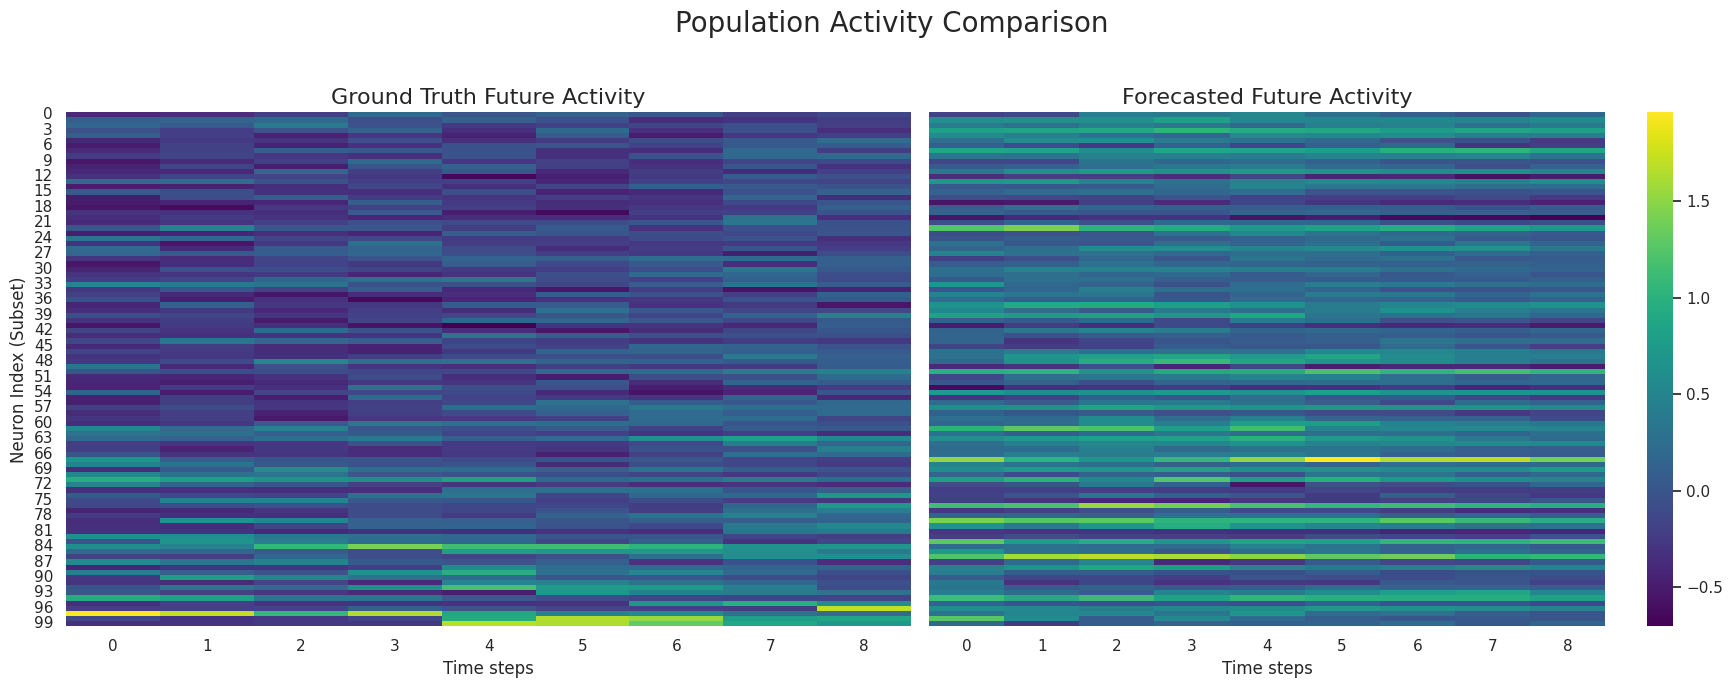

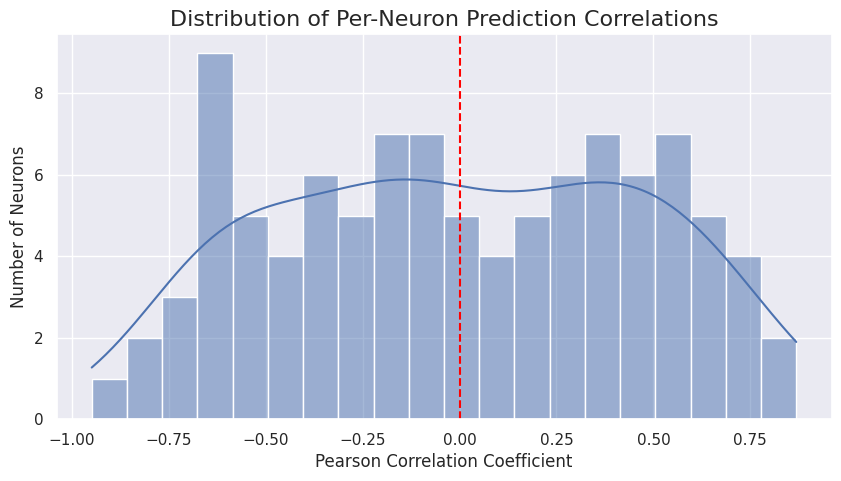

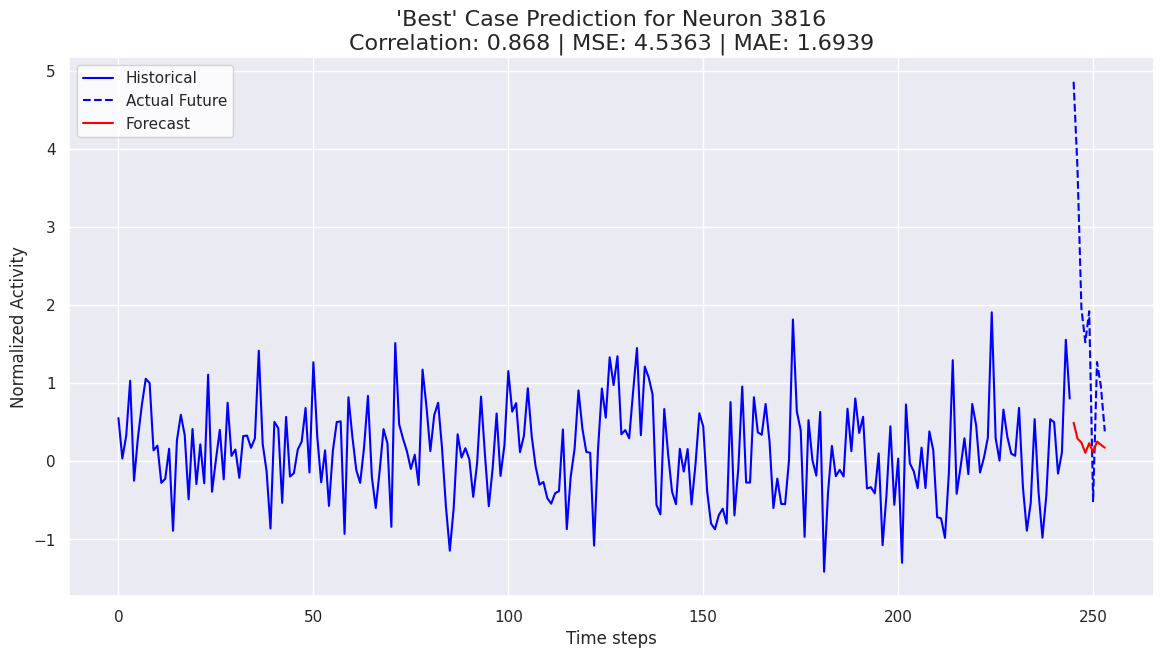

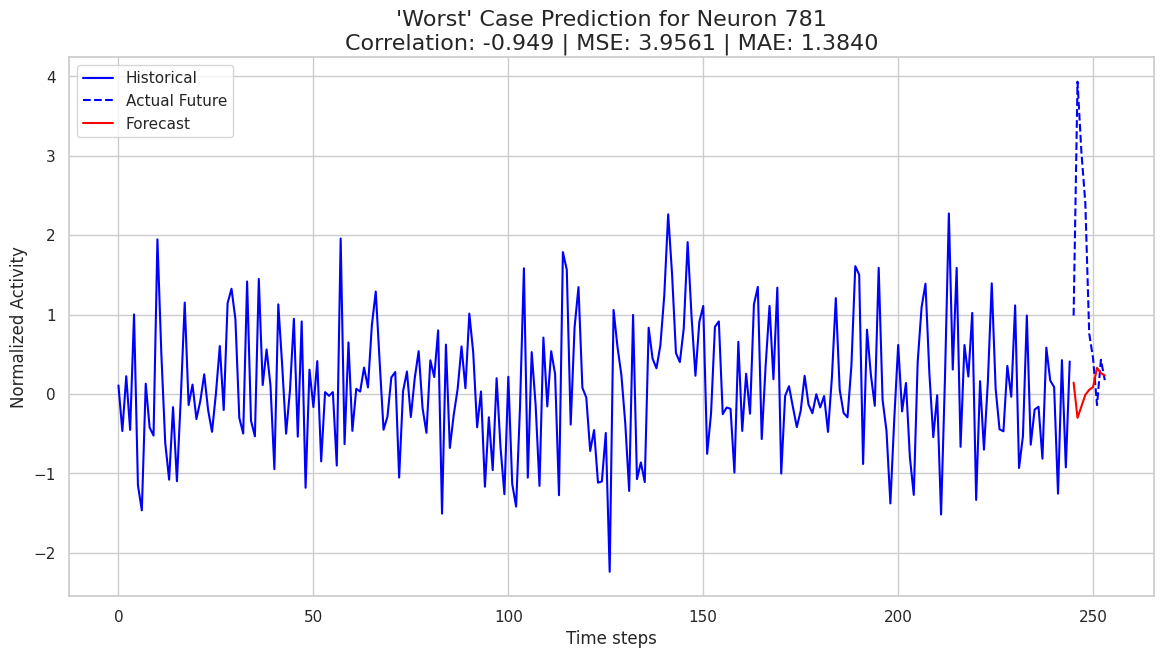

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import InformerForPrediction
from scipy.stats import pearsonr

# ===================================================================
# Step 1: Load Model & Set to Evaluation Mode (No Changes)
# ===================================================================
print("STEP 1: Loading trained model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "./informer_calcium_model_continuous" 
model = InformerForPrediction.from_pretrained(output_dir)
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")


# ===================================================================
# Step 2: Select & Generate a Sample (No Changes)
# ===================================================================
print("\nSTEP 2: Preparing a sample using the lazy dataset and generating forecast...")

# --- CONTROL PANEL: CHOOSE YOUR STARTING TIME POINT HERE ---
EVALUATION_START_INDEX = 2900

try:
    (past_val_sample, past_time_sample, 
     future_val_sample, future_time_sample, _) = full_dataset[EVALUATION_START_INDEX]
    sample_idx = EVALUATION_START_INDEX
except (NameError, IndexError) as e:
    print(f"Could not fetch sample. Error: {e}")
    exit()

print(f"Evaluating window starting at time point: {sample_idx}")

# --- Prepare the inference input batch ---
inference_input = {
    "past_values": past_val_sample.unsqueeze(0).to(device),
    "past_time_features": past_time_sample.unsqueeze(0).to(device),
    "future_time_features": future_time_sample.unsqueeze(0).to(device)
}

# --- Generate the forecast ---
with torch.no_grad():
    outputs = model.generate(**inference_input)
forecast_sequences = outputs.sequences.mean(dim=1).cpu().squeeze().numpy()
print("Forecast generated successfully.")


# ===================================================================
# Step 3 and onward (MODIFIED TO INCLUDE MORE METRICS)
# ===================================================================

print("\nSTEP 3: Performing population-level evaluation with more metrics...")

# --- A. Get Ground Truth from Original Source ---
start_slice = sample_idx
end_slice = sample_idx + past_sequence_length + prediction_length
ground_truth_window = activity_matrix_normalized[start_slice:end_slice, :]
ground_truth_future = ground_truth_window[-prediction_length:]

# --- B. NEW: Calculate Overall Performance Metrics ---
# Convert to tensors for easy calculation with torch.nn.functional
gt_tensor = torch.from_numpy(ground_truth_future)
fc_tensor = torch.from_numpy(forecast_sequences)

overall_mse = F.mse_loss(fc_tensor, gt_tensor).item()
overall_mae = F.l1_loss(fc_tensor, gt_tensor).item()

print("\n--- Overall Performance (All Neurons) ---")
print(f"  Mean Squared Error (MSE): {overall_mse:.6f}")
print(f"  Mean Absolute Error (MAE): {overall_mae:.6f}")

# --- C. Select a Neuron Subset for Deeper Analysis ---
future_variances = np.var(ground_truth_future, axis=0)
top_100_indices = np.argsort(future_variances)[-100:]
ground_truth_subset = ground_truth_future[:, top_100_indices]
forecast_subset = forecast_sequences[:, top_100_indices]
print(f"\n--- Analysis on Subset of 100 Most Active Neurons ---")
print(f"Selected a subset of 100 neurons with highest future variance.")

# --- D. Calculate Population Metrics on Subset ---
gt_sparsity = np.mean(ground_truth_subset < 0.01) # Using a low threshold for dense data
fc_sparsity = np.mean(forecast_subset < 0.01)
print(f"Sparsity (GT vs. Forecast): {gt_sparsity:.2f} vs. {fc_sparsity:.2f}")

gt_mean_activity = np.mean(ground_truth_subset)
fc_mean_activity = np.mean(forecast_subset)
print(f"Mean Activity (GT vs. Forecast): {gt_mean_activity:.4f} vs. {fc_mean_activity:.4f}")

correlations = [pearsonr(ground_truth_subset[:, i], forecast_subset[:, i])[0] for i in range(ground_truth_subset.shape[1])]
correlations = np.nan_to_num(correlations)
print(f"Mean Correlation across {len(top_100_indices)} neurons: {np.mean(correlations):.3f}")

# --- E. Population Raster Plots (No changes) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.set_theme(style="darkgrid")
sns.heatmap(ground_truth_subset.T, cmap="viridis", ax=axes[0], cbar=False)
axes[0].set_title("Ground Truth Future Activity", fontsize=16)
axes[0].set_xlabel("Time steps"); axes[0].set_ylabel("Neuron Index (Subset)")
sns.heatmap(forecast_subset.T, cmap="viridis", ax=axes[1])
axes[1].set_title("Forecasted Future Activity", fontsize=16)
axes[1].set_xlabel("Time steps"); axes[1].set_ylabel("")
fig.suptitle("Population Activity Comparison", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

# --- F. Histogram of Correlations (No changes) ---
plt.figure(figsize=(10, 5)); sns.histplot(correlations, bins=20, kde=True)
plt.title("Distribution of Per-Neuron Prediction Correlations", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient"); plt.ylabel("Number of Neurons")
plt.axvline(0, color='red', linestyle='--'); plt.show()

# --- G. Plot Best and Worst Predicted Neurons with More Metrics ---
best_idx_in_subset, worst_idx_in_subset = np.argmax(correlations), np.argmin(correlations)
best_neuron_original_idx, worst_neuron_original_idx = top_100_indices[best_idx_in_subset], top_100_indices[worst_idx_in_subset]

for case, neuron_idx_in_subset, original_idx, corr_val in [
    ("Best", best_idx_in_subset, best_neuron_original_idx, np.max(correlations)),
    ("Worst", worst_idx_in_subset, worst_neuron_original_idx, np.min(correlations))
]:
    historical_activity = ground_truth_window[:-prediction_length, original_idx][-context_length:]
    actual_future_activity = ground_truth_subset[:, neuron_idx_in_subset]
    forecast_activity = forecast_subset[:, neuron_idx_in_subset]
    
    # Calculate MSE and MAE for this specific neuron
    neuron_mse = F.mse_loss(torch.from_numpy(forecast_activity), torch.from_numpy(actual_future_activity)).item()
    neuron_mae = F.l1_loss(torch.from_numpy(forecast_activity), torch.from_numpy(actual_future_activity)).item()
    
    fig_case, ax_case = plt.subplots(figsize=(14, 7)); sns.set_theme(style="whitegrid")
    sns.lineplot(x=np.arange(context_length), y=historical_activity, ax=ax_case, color="blue", label="Historical")
    sns.lineplot(x=np.arange(context_length, context_length + prediction_length), y=actual_future_activity, ax=ax_case, color="blue", linestyle="--", label="Actual Future")
    sns.lineplot(x=np.arange(context_length, context_length + prediction_length), y=forecast_activity, ax=ax_case, color="red", label="Forecast")
    
    # Add all metrics to the plot title
    title = (f"'{case}' Case Prediction for Neuron {original_idx}\n"
             f"Correlation: {corr_val:.3f} | MSE: {neuron_mse:.4f} | MAE: {neuron_mae:.4f}")
    ax_case.set_title(title, fontsize=16); ax_case.set_xlabel("Time steps"); ax_case.set_ylabel("Normalized Activity")
    ax_case.legend(); plt.show()